<a href="https://colab.research.google.com/github/BKover99/Pseudovisium/blob/main/Paper%20figures/Fig6_Brain_datasets_merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!wget https://github.com/BKover99/Pseudovisium/raw/main/Datasets_all.xlsx
!pip install Pseudovisium -q --upgrade
!pip install pympler -q
!pip install harmonypy -q
!pip install spatialAUC -q

--2024-06-23 12:11:48--  https://github.com/BKover99/Pseudovisium/raw/main/Datasets_all.xlsx
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BKover99/Pseudovisium/main/Datasets_all.xlsx [following]
--2024-06-23 12:11:48--  https://raw.githubusercontent.com/BKover99/Pseudovisium/main/Datasets_all.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42197 (41K) [application/octet-stream]
Saving to: ‘Datasets_all.xlsx.2’

Datasets_all.xlsx.2 100%[===================>]  41.21K  --.-KB/s    in 0.04s   

2024-06-23 12:11:48 (1016 KB/s) - ‘Datasets_all.xlsx.2’ saved [42197/42197]



In [3]:
import pandas as pd
from os import system
import os
import time
import squidpy as sq
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from pympler import asizeof
import seaborn as sns
import scipy.stats as stats
import sklearn.metrics as metrics
import shutil
import subprocess
import concurrent.futures
# Set the random seed
np.random.seed(42)

def find_csv_with_transcript(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if ((file.endswith('.csv') or file.endswith('.csv.gz')) and (('transcript' in file.lower() or 'tx' in file.lower()))) and 'macosx' not in root.lower():
                return os.path.join(root, file)
    return None

def find_any_file_within_folder(folder_path,end):
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            #if (file.endswith(end) or file.endswith(end+"") and 'macosx' not in root.lower():
            if (file.endswith(end) or file.endswith(end+".gz")) and 'macosx' not in root.lower():
                return os.path.join(root, file)
    return None

/usr/local/lib/python3.10/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.3-CAPI-1.17.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/spatialdata/__init__.py:11: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/usr/local/lib/python3.10/dist-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/driver.py", line 295, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA dri

In [4]:
datasets = pd.read_excel("/content/Datasets_all.xlsx")
datasets_to_use = datasets[datasets["Dataset_merge_visium"]==1]
#remove those without link
datasets_to_use = datasets_to_use[~datasets_to_use["Onedrive_link"].isna()]
datasets_to_use.reset_index(drop=True,inplace=True)
datasets_to_use

,Author,Year,Paper_DOI,Link_to_dataset,Onedrive_link,Name,Technology,Tissue,Species,Visium_xenium_notebook,PV_workflow_comparison,Comparing_all_tech,Pulmonary Xenium,Cosmx_lung,Dataset_merge_visium,Brain case study,Just Visium example
0,Nanostring,2023,NaN,https://nanostring.com/products/cosmx-spatial-...,https://ywobqw.bl.files.1drv.com/y4mnkgdMt9PQD...,CosMx_mouse_brain,CosMx,Brain,Mouse,0,1,1,0,0,1,1,0
1,10X,2024,NaN,https://www.10xgenomics.com/datasets/visium-hd...,https://kqaaxa.bl.files.1drv.com/y4m1vncufYYbE...,Visium_HD_brain_2um,Visium_HD,Brain_2um,Mouse,0,1,1,0,0,1,0,0
2,Wu et al.,2024,https://doi.org/10.1111/acel.14109,GSM5773453,https://jcgr5w.bl.files.1drv.com/y4mdpOjO3J91P...,Visium_GSM5773453,Visium,Brain,Mouse,0,0,1,0,0,1,0,1
3,Wu et al.,2024,https://doi.org/10.1111/acel.14109,GSM5773457,https://kd25iq.bl.files.1drv.com/y4m0bQ8gUOcrd...,Visium_GSM5773457,Visium,Brain,Mouse,0,0,1,0,0,1,0,1


In [5]:
def download_and_unzip(dataset):
    try:
        download_link = dataset["Onedrive_link"]
        name = dataset["Name"]
        print(f"Processing dataset: {name}")
        print(f"Download link: {download_link}")

        command = "wget {}".format(download_link)
        subprocess.run(command, shell=True, check=True)

        filename = download_link.split("com/")[-1]
        archive_name = filename.split("/")[-1]

        if name == "Xenium_whole_mouse_pup":
            filename = "Xenium_V1_mouse_pup_outs.zip"

        try:
            command_unzip = "unzip -d /content/{} /content/{}".format(name, filename)
            print(command_unzip)
            subprocess.run(command_unzip, shell=True, check=True)
            print("Successfully unzipped {}.".format(archive_name))
            os.remove("/content/{}".format(filename))  # Remove the zip file
        except subprocess.CalledProcessError:
            print("Failed to unzip {}. Attempting other methods.".format(archive_name))

            try:
                command_gunzip = "gunzip -d /content/{} /content/{}".format(name, filename)
                subprocess.run(command_gunzip, shell=True, check=True)
                print("Successfully gunzipped {}.".format(archive_name))
                os.remove("/content/{}".format(filename))   # Remove the zip file
            except subprocess.CalledProcessError:
                print("Failed to gunzip {}. Attempting other methods.".format(archive_name))

                try:
                    os.makedirs("/content/{}".format(name), exist_ok=True)
                    command_untar = "tar -xvf /content/{} -C /content/{}".format(filename, name)
                    subprocess.run(command_untar, shell=True, check=True)
                    print("Successfully untarred {}.".format(archive_name))
                    os.remove("/content/{}".format(filename))   # Remove the zip file
                except subprocess.CalledProcessError:
                    try:

                      command_untar = "tar -xvzf /content/{} -C /content/{}".format(filename, name)
                      subprocess.run(command_untar, shell=True, check=True)
                      print("Successfully untarred {}.".format(archive_name))
                      os.remove("/content/{}".format(filename))   # Remove the zip file
                    except:
                      print("All methods failed to extract {}.".format(archive_name))

    except KeyError as e:
        print(f"Error: Missing required column in dataset: {str(e)}")
    except subprocess.CalledProcessError as e:
        print(f"Error: Command failed: {str(e)}")
    except Exception as e:
        print(f"Error: An unexpected error occurred: {str(e)}")

# Create a thread pool with a maximum of 10 threads
with concurrent.futures.ThreadPoolExecutor(max_workers=16) as executor:
    # Submit download and unzip tasks to the thread pool
    futures = [executor.submit(download_and_unzip, row.to_dict()) for _, row in datasets_to_use.reset_index(drop=True).iterrows()]

    # Wait for all tasks to complete
    concurrent.futures.wait(futures)


Processing dataset: CosMx_mouse_brain
Download link: https://ywobqw.bl.files.1drv.com/y4mnkgdMt9PQDjy_KeoASubj2GkF8Ro0xggVKMegwWL2EqBQaVXMq6-28emVeQKpe0pY0vf-ZaMWUR1jhZTcg555duknK_p6Se7HsxcI7b3UdOPpNAQLS7_XUQ9lK2T4IIfsfLe4wGjlWPXkp5Jb0LL9z23hgY32LnPowmzrS585zsjjDLKCZBLP6-lyhTHfG3ug-xMX8wGjNb2GWaUYXJzYQ
Processing dataset: Visium_HD_brain_2um
Download link: https://kqaaxa.bl.files.1drv.com/y4m1vncufYYbEWZeyFeKzMMc4HwleEa84uMsxq5y0Nz-u0CTrcKxavxG-b8Rt4kUUaBIWhhdnOHewUUs_45YDFWu89PZTazp1uZ6XF-lVWq18jc-fE37Tf_4JOk11oQPYwnQt18hM2TivzFar_ZspH8VhxPGnpAps_AROgOtDeA6ysgso-HAKQ9HoA4uwrxbkAs-auxb_46FMs4cARZR-r9iQ
Processing dataset: Visium_GSM5773453
Download link: https://jcgr5w.bl.files.1drv.com/y4mdpOjO3J91PV7eKQaNDUYgfVzXhkbkBMQ2ZHU1bVY7_pV8chlQC900W9495nIm7_LnjFlvoPGty6bjhrA7ix08ErbY0nAiX4uzF7C27OGhyYQ8VW-qmJlh7gUkX4TocxKVW-01K0MBgKr2BIIW7oZ5Sxb3QZ6ie0J50WfzYFsifh8sDL43FIJV-oexwmW4g_u980KZgxk73WpfoRh8Drdvg
Processing dataset: Visium_GSM5773457
Download link: https://kd25iq.bl.files.1drv.com/

In [7]:
from Pseudovisium.pseudovisium_generate import generate_pv
output_path="/content/"
hexagon_size=50
max_workers=10
errors=[]
for i in range(len(datasets_to_use)):
    try:
      start_pv = time.time()
      technology = datasets_to_use["Technology"].values[i]
      name=datasets_to_use["Name"].values[i]
      img_file_path=None
      if technology != "Visium_HD" and technology != "Curio":
        csv_file = find_csv_with_transcript("/content/"+name+"/")
        print(csv_file)
        visium_hd_folder=None
      elif technology == "Visium_HD":
        csv_file = None
        img_file_path = "/content/Visium_HD_brain_2um/square_002um_mouse_brain/spatial/tissue_hires_image.png"
        visium_hd_folder = find_any_file_within_folder("/content/"+name+"/","filtered_feature_bc_matrix.h5").split("filtered_feature_bc_matrix.h5")[0]
      elif technology == "Curio":
        visium_hd_folder = find_any_file_within_folder("/content/"+name+"/","h5ad").split("Puck")[0]

      if technology == "CosMx":
      #getting unique cell names for old SMI data
        df = pd.read_csv(csv_file)

        # Create a new column called 'cell' by concatenating 'fov' and 'cell_ID' columns
        df['cell'] = df['fov'].astype(str) + '_' + df['cell_ID'].astype(str)

        # Save the updated DataFrame back to the original CSV file
        df.to_csv(csv_file, index=False)
        technology = "CosMx"

      print(technology)
      print(visium_hd_folder)

      quality_filter = True if technology=="Xenium" else False
      ctu= 0.12028 if technology=="CosMx" else 1
      print(ctu)

      generate_pv(csv_file=csv_file,
                  visium_hd_folder=visium_hd_folder,
                  hexagon_size=hexagon_size,
                  output_path=output_path,
                  img_file_path=img_file_path,
                  batch_size=5000000,
                  technology=technology,
                  max_workers=max_workers,
                  quality_filter=quality_filter,
                  project_name=name,
                  coord_to_um_conversion=ctu,
                  shift_to_positive=True)


      end_pv = time.time()
      time_pv = end_pv-start_pv
      results[name]={}
      results[name]["time_pv"]=time_pv
      print(results)
    except:
      errors.append(name)
      print(errors)

/content/CosMx_mouse_brain/mouse brain parts/Brain_files/Run1000_S1_Half_tx_file.csv


<ipython-input-7-8a78747d003b>:25: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


CosMx
None
0.12028
You are using version:  ['Pseudovisium==0.0.42']
Date:  2024-06-23
Technology is Nanostring. Going forward with default column names.
Quality filter is set to False
Quality counting per hexagon is set to False
Quality counting per probe is set to False
Created temporary directory /tmp/tmp_hexa2jdp3690
Now creating batches
Created batch 1
Created batch 2
Created batch 3
Created batch 4
Created batch 5
Created batch 6
Created batch 7
Created batch 8
Created batch 9
Created batch 10
Created batch 11
Created batch 12
Created batch 13
Created batch 14
Created batch 15
Created batch 16
Created batch 17
Created batch 18
Created batch 19
Created batch 20
Created batch 21
Created batch 22
Created batch 23
Created batch 24
Finished preprocessing. Total batches created: 24
Processing batches using 8 processes


Processing batches: 100%|██████████| 24/24 [03:45<00:00,  9.39s/batch]


Creating pseudovisium folder in output path:/content//pseudovisium/CosMx_mouse_brain
Creating scalefactors_json.json file in spatial folder.
Creating barcodes.tsv.gz file in spatial folder.
Creating tissue_positions_list.csv file in spatial folder.
Creating pv_cell_hex.csv file in spatial folder.
No quality information provided. Skipping quality information files.
No quality information provided. Skipping quality information files.
Creating features.tsv.gz file in spatial folder.
Putting together the matrix.mtx file
Total matrix count: 116159827.0
Number of unique hexagons: 4062
Creating matrix.mtx.gz file in spatial folder.


/usr/local/lib/python3.10/dist-packages/Pseudovisium/pseudovisium_generate.py:795: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hexagon_cell_counts["hexagon_id"] = hexagon_cell_counts["hexagon_id"] + 1


Putting together the filtered_feature_bc_matrix.h5 file
No image file provided. Drawing tissue positions on a white background.
Creating arguments.json file in output path.
Time taken: 965.2190041542053 seconds
Searching for temporary batch files in: /tmp
No remaining temporary batch files found.
['CosMx_mouse_brain']
Visium_HD
/content/Visium_HD_brain_2um/square_002um_mouse_brain/
1
You are using version:  ['Pseudovisium==0.0.42']
Date:  2024-06-23
Technology is Visium_HD. Generating transcripts.csv file from Visium HD files.


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Searching for temporary batch files in: /tmp
No remaining temporary batch files found.
['CosMx_mouse_brain', 'Visium_HD_brain_2um']


KeyboardInterrupt: 

In [ ]:
from Pseudovisium.pseudovisium_merge import merge_visium
# Define the folders and output path
folders = ["/content/Visium_GSM5773453/GSM5773453/GSM5773453_Young_mouse_brain_A1-1/",
           "/content/Visium_GSM5773457/GSM5773457/GSM5773457_Old_mouse_brain_A1-2/",
           "/content/pseudovisium/Visium_HD_brain_2um/",
           "/content/pseudovisium/CosMx_mouse_brain/",
           ]
output_path = "/content/"

merge_visium(folders, output_path, "merged", pv_format=False,only_common=True)



In [ ]:
import squidpy as sq
import scanpy as sc
import numpy as np
import scanpy.external as sce
adata = sq.read.visium("/content/pseudovisium/merged",library_id="library")
adata.obs["sum"]=adata.X.sum(axis=1)
adata.obs["logsum"]=np.log10(adata.X.sum(axis=1))
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sq.gr.spatial_neighbors(adata, radius=250, coord_type="generic", delaunay=True)
indices = adata.obs.index
adata.obs['dataset'] = np.where(indices.str.contains('CosMx'), 'CosMx',
                                np.where(indices.str.contains('HD'), 'Visium HD', 'Visium'))

In [ ]:
adata_visium = adata[adata.obs["dataset"]=="Visium"]
sq.gr.spatial_autocorr(adata_visium, mode="moran", n_perms=100, n_jobs=4)
genes_visium = adata_visium.uns["moranI"][:500].index.values

adata_cosmx = adata[adata.obs["dataset"]=="CosMx"]
sq.gr.spatial_autocorr(adata_cosmx, mode="moran", n_perms=100, n_jobs=4)
genes_cosmx = adata_cosmx.uns["moranI"][:500].index.values

adata_hd = adata[adata.obs["dataset"]=="Visium HD"]
sq.gr.spatial_autocorr(adata_hd, mode="moran", n_perms=100, n_jobs=4)
genes_hd = adata_hd.uns["moranI"][:500].index.values

# Find the overlap between the three arrays
common_genes = np.intersect1d(genes_visium, np.intersect1d(genes_cosmx, genes_hd))

# Print the common genes
print("First 10 common genes:", common_genes[:10])


In [ ]:
# Create a boolean mask for common genes in adata.var.index
mask = adata.var.index.isin(common_genes)

# Subset the adata object to keep only the common genes
adata_common = adata[:, mask]

# Print the shape of the subsetted adata
print("Shape of subsetted adata:", adata_common.shape)

In [ ]:
sc.pp.scale(adata_common)
sc.pp.pca(adata_common)
sce.pp.harmony_integrate(adata_common, 'dataset',max_iter_harmony=30, plot_convergence=True)
adata_common.obsm['X_pca'] = adata_common.obsm['X_pca_harmony']
sc.pp.neighbors(adata_common, n_neighbors=30, n_pcs=20)
sc.tl.leiden(adata_common, resolution=0.5, key_added="leiden",flavor='igraph')


In [ ]:
sq.pl.spatial_scatter(adata_common, color="leiden",img=True,alpha=0.0)
plt.savefig("tissue.svg")
plt.savefig("tissue.png")

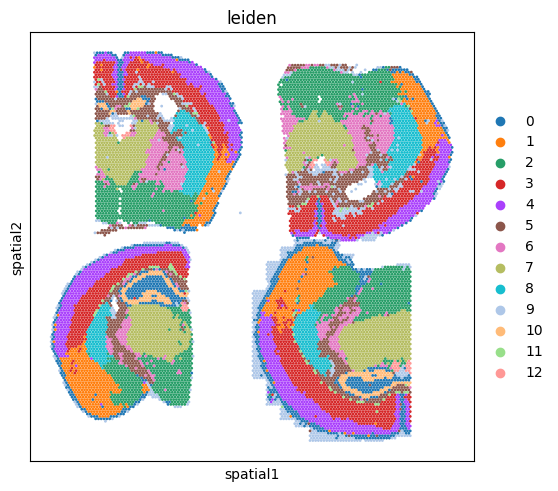

In [48]:
sq.pl.spatial_scatter(adata_common, color="leiden",img=False)
plt.savefig("leiden.svg")
plt.savefig("leiden.png")

In [ ]:
from spatialAUC.spatialAUC import get_df_from_gmt, get_auc
adata_common.var.index = [gene.capitalize() for gene in adata_common.var.index]
genes = list(set(adata_common.var_names) & set(adata_common.var_names))

df = get_df_from_gmt(['m5.all', 'm2.all'],'2023.1.Mm', genes,min_gene_ratio=0.3, min_gene_count=5)

new_adata_pv = get_auc(adata_common, df, axis=0)
new_adata_pv.obsm["spatial"]=adata_common.obsm["spatial"]
new_adata_pv.uns["spatial"]=adata_common.uns["spatial"]

In [ ]:
sq.gr.spatial_autocorr(new_adata_pv, mode="moran", n_perms=100, n_jobs=4)
new_adata_pv.uns["moranI"]


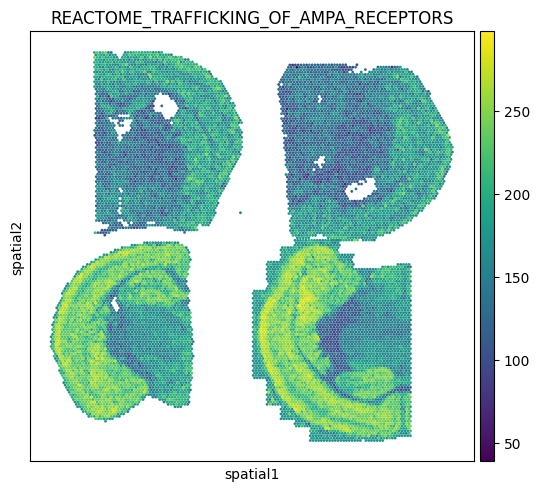

In [49]:
sq.pl.spatial_scatter(new_adata_pv, color="REACTOME_TRAFFICKING_OF_AMPA_RECEPTORS",img=False)
plt.savefig("gsea.svg")
plt.savefig("gsea.png")

In [46]:
adata_common.var

,gene_ids,feature_types,genome,mean,std
Abca2,ABCA2,Gene Expression,pv_placeholder,2.106760,0.848184
Abi2,ABI2,Gene Expression,pv_placeholder,1.586890,0.932914
Adam22,ADAM22,Gene Expression,pv_placeholder,1.630631,0.954399
Adar,ADAR,Gene Expression,pv_placeholder,1.605119,0.866968
Adcy1,ADCY1,Gene Expression,pv_placeholder,2.150268,1.218021
...,...,...,...,...,...
Wasf1,WASF1,Gene Expression,pv_placeholder,1.788218,1.046017
Wscd1,WSCD1,Gene Expression,pv_placeholder,1.435124,0.919950
Ywhag,YWHAG,Gene Expression,pv_placeholder,3.521462,0.991774
Ywhaq,YWHAQ,Gene Expression,pv_placeholder,2.959380,0.912021


  0%|          | 0/100 [00:00<?, ?/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


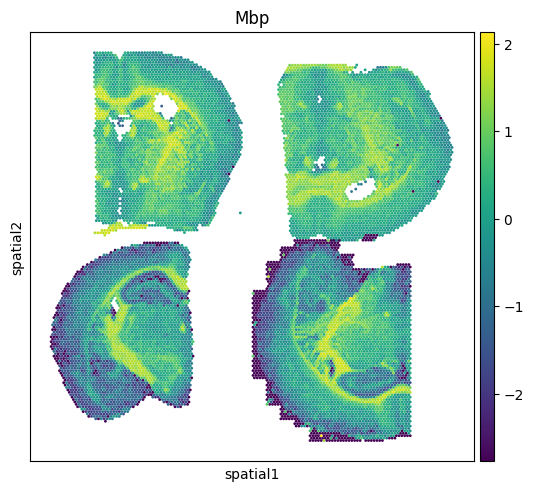

In [47]:
sq.gr.spatial_autocorr(adata_common, mode="moran", n_perms=100, n_jobs=4)
adata_common.uns["moranI"]
sq.pl.spatial_scatter(adata_common, color="Mbp",img=False)
plt.savefig("mbp.svg")
plt.savefig("mbp.png")